<a href="https://colab.research.google.com/github/Gilours123/Projet_SIG/blob/main/Projet_SIG_S%C3%A9isme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet SIG - Majeure Numérique**
Rendu de Virgile Zucchiatti


# Etude de l'impact des séismes sur les villes japonaises

# Contexte et Intérêt

Le Japon est un archipel situé à la frontière de plusieurs plaques tectoniques majeures : la plaque pacifique, la plaque philippine, la plaque eurasienne et la plaque nord-américaine. Cette position géologique particulière place le pays au cœur de l’une des zones les plus sismiquement actives du monde, appelée la ceinture de feu du Pacifique. Les mouvements de subduction et de collision entre ces plaques engendrent une activité sismique intense, responsable de milliers de secousses chaque année, dont certaines peuvent être dévastatrices.

Le relief japonais, marqué par de nombreuses chaînes montagneuses et volcans actifs, témoigne de cette dynamique géologique permanente. Les séismes y sont non seulement fréquents mais aussi variés en intensité et en profondeur. Les grandes villes comme Tokyo, Osaka, Sendai ou Kobe se trouvent souvent proches de failles actives, exposant la population et les infrastructures à des risques élevés.

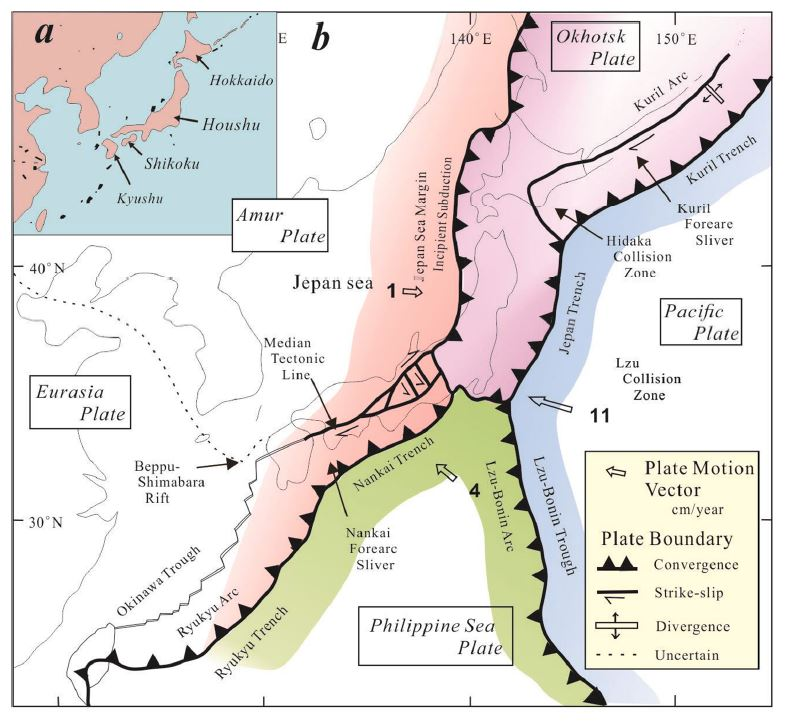

Plaques lithosphériques du système d’arcs du Japon selon Windley et al., 2021. Les vitesses sont indiquées en centimètres par an. Trench = fosse, trough = fossé

L’analyse des séismes survenus depuis l’an 2000 permet de mieux comprendre la répartition spatiale et temporelle de l’activité sismique au Japon. Identifier les villes touchées par des séismes d’amplitude supérieure à 6,1 offre une vision concrète des zones les plus exposées. Cette approche contribue à :

*   évaluer la récurrence des phénomènes sismiques dans différentes régions,
*   renforcer la connaissance des zones à risque pour la planification urbaine et la prévention,

Ce travail s’inscrit donc dans une démarche à la fois scientifique et appliquée, visant à mieux comprendre les dynamiques sismiques à l’échelle régionale.

# **Avant de lancer les traitements :**

Afin de mener cette étude, les données ont été récoltées en ligne.


*   Les données relatives aux villes japonaises ont été obtenues sur **MapCruizin** (mapcruzin.com/free-japan-country-city-place-gis-shapefiles.htm) et sont téléchargeables à travers ce lien : [Lien](https://mapcruzin.com/japan-shapefiles/japan_location.zip)
*   Les données relatives aux séismes ayant eu lieu autour du Japon depuis 2000 ont été obtenues sur le site de l'**USGS**, l'*US Geological Survey* ([Lien](https://www.usgs.gov/)) et sont téléchargeables à travers ce lien : [Lien](https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime=2020-01-01%2000:00:00&endtime=2025-11-11%2023:59:59&maxlatitude=51.408&minlatitude=20.317&maxlongitude=165.867&minlongitude=112.078&minmagnitude=2.5&maxmagnitude=10&orderby=time )

Les données doivent être chargées sur le Colab avant de pouvoir effectuer les traitements.

Avant d'exécuter les lignes de code suivantes, vérifiez que les fichiers *query.csv*, ainsi que l'ensemble des données shapefile *japan_location.dbf*, *japan_location.prj*, *japan_location.shp* et *japan_location.shx* sont bien uploadés dans les contenus du notebook.

Les données peuvent être téléchargées depuis les liens de la section précédente, ou sur le GitHub du projet : [Lien](https://github.com/Gilours123/Projet_SIG)

# **Traitements :**

Import des librairies :

In [23]:
# Import des librairies
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import folium
from IPython.display import display

Chargement des données :

In [24]:
# Import des villes du Japon
villes = gpd.read_file("japan_location.shp", encoding="cp932") # Le code 'encoding' est la norme utilisée pour lire les données japonaises

# Import des séismes
seismes = pd.read_csv("query.csv")

/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:198: RuntimeWarning: One or several characters couldn't be converted correctly from cp932 to UTF-8.  This warning will not be emitted anymore
  return ogr_read(


Filtrage des séismes d'une magnétude supérieure à 6,1 :

In [25]:
# Comme les données récoltées sur le site de l'USGS ont une étendues plus larges que le japon, on se limitent aux séismes compris entre les coordonnées du japon :

seismes_japon = seismes[
    (seismes.latitude >= 24) & (seismes.latitude <= 46) &
    (seismes.longitude >= 123) & (seismes.longitude <= 146) &
    (seismes.mag >= 6.1)]

print(f"Nombre de séismes retenus : {len(seismes_japon)}") # Affiche le nombre de séismes d'une magnétude > 6,1 au Japon depuis 2000

# Transformer en GeoDataFrame
geometry = [Point(xy) for xy in zip(seismes_japon.longitude, seismes_japon.latitude)]
seismes_gdf = gpd.GeoDataFrame(seismes_japon, geometry=geometry, crs="EPSG:4326")

Nombre de séismes retenus : 33


Création de la zone d'impact des séismes (100 km)

In [26]:
# On projette les données selon un système de coordonnées local/japonais (JGD2011 - Japan Plane Rectangular CS IX / EPSG:6677), pour avoir des distances correctes :
seismes_proj = seismes_gdf.to_crs(epsg=6677)
villes_proj = villes.to_crs(epsg=6677)

# On fait le buffer de 100 km, soit 100 000 m :
seismes_proj['geometry'] = seismes_proj.geometry.buffer(100000)
zones_impact = seismes_proj[['geometry']].copy()
zones_impact.crs = seismes_proj.crs

Identification des villes impactées par les séismes

In [27]:
villes_touchées = gpd.sjoin(villes_proj, zones_impact, how='inner', predicate='intersects') # On fait un join pour obtenir les villes présentes dans les buffers d'impact des séismes

# On repasse en WGS84 (EPSG:4326) pour afficher correctement la carte par la suite à l'aide de Folium (EPSG:4326)
villes_touchées = villes_touchées.to_crs(epsg=4326)
seismes_gdf = seismes_gdf.to_crs(epsg=4326)
zones_impact = zones_impact.to_crs(epsg=4326)

print(f"Nombre de villes impactées par des séismes d'une magnétude supérieure à 6,1 depuis 2000 : {len(villes_touchées)}") # Affiche le nombre de villes impactées par les séismes

Nombre de villes impactées par des séismes d'une magnétude supérieure à 6,1 depuis 2000 : 1103


Création de la carte intéractive

In [28]:
m = folium.Map(location=[36, 138], zoom_start=5, tiles='cartodbpositron', control_scale=True) # Création de la carte avec Folium, avec échelle

# Affichage des zones d'impact en orange
for _, row in zones_impact.iterrows():
    folium.Circle(
        location=[row.geometry.centroid.y, row.geometry.centroid.x],
        radius=100000,  # Buffer de 100 km
        color='orange',
        fill=True,
        fill_opacity=0.2,).add_to(m)

# Afficahge de l'épicentre des séismes en rouge
for _, row in seismes_gdf.iterrows():
    folium.CircleMarker(
        location=[row.latitude, row.longitude],
        radius=5,
        color='red',
        fill=True,
        fill_opacity=0.7,
        popup=f"Magnitude : {row.mag}, Date : {row.time if 'time' in row else 'N/A'}").add_to(m) # Affiche les données du séismes en survolant le point

# Affichage des villes touchées par les séismes en bleu
for _, row in villes_touchées.iterrows():
    nom_ville = str(row.NAME).encode('utf-8', errors='ignore').decode('utf-8') # Cette ligne sert à encoder correctement le nom des villes présentes sous forme de kanjis dans le shapefile afin de les afficher correctement sur la carte
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color='blue',
        fill=True,
        fill_opacity=0.9,
        popup=f"Ville : {nom_ville}").add_to(m) # Affiche le nom de la ville en survolant le point correspondant


# Création de la légende :

legend = '''<div style="position: fixed;
bottom: 40px; left: 20px; width: 200px;
background-color: white;
border:2px solid grey;
z-index:9999;
font-size:14px;
padding: 10px;">
<b>Légende</b><br>
<span style="color:red;">●</span> Séisme (≥6.1)<br>
<span style="color:orange;">⬤</span> Zone d'impact (100 km)<br>
<span style="color:blue;">●</span> Ville touchée
</div>'''
# Les figurés sont sous forme de symboles

m.get_root().html.add_child(folium.Element(legend)) # Ajout de la légende à la carte

**Affichage de la carte intéractive :**

In [29]:
display(m)

**Export de la carte en HTML :**

In [30]:
m.save("carte_japon_seismes.html") # Enregistre la carte dans les données du Colab
print("Carte sauvegardée : carte_japon_seismes.html")

Carte sauvegardée : carte_japon_seismes.html


Teléchargement de la carte :

In [31]:
from google.colab import files # Récupération de la carte depuis les fichiers du Colab
files.download("carte_japon_seismes.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# On peut ainsi afficher la liste de l'ensemble des villes impactées par les séismes d'une magnétude supérieur à 6,1 depuis l'an 2000 :

In [32]:
villes_touchées.columns = villes_touchées.columns.str.strip()
villes_touchées[['NAME', 'PLACE', 'ADDR:HOUSE', 'ADDR:POSTC', 'index_right']]


,NAME,PLACE,ADDR:HOUSE,ADDR:POSTC,index_right
15,螟ｧ豁｣蟲ｶ,island,None,None,5158
205,Mos Burger,None,1-14-6,None,3227
212,鮖ｿ蜈仙ｳｶ蟶 (Kagoshima),city,None,None,3227
212,鮖ｿ蜈仙ｳｶ蟶 (Kagoshima),city,None,None,2525
213,鮖ｿ蜈仙ｳｶ逵 (Kagoshima),region,None,None,3227
...,...,...,...,...,...
2935,譌･鬮倡伴,town,None,None,5578
2944,蜊怜ｯ瑚憶驥守伴 (Minamifurano),town,None,None,5578
2949,豬ｦ豐ｳ逕ｺ (Urakawa),town,None,None,5578
2952,譁ｰ蠕礼伴 (Shintoku),town,None,None,5578


La carte met en évidence la forte activité tectonique du pays, liée à sa position au croisement de plaques lithosphériques majeures.

Les résultats montrent que :

* Les séismes de forte magnitude (≥ 6,1) se concentrent principalement le long de la fosse du Japon, au large de la côte pacifique de Honshū, mais aussi dans les régions méridionales de Kyūshū et des îles Ryūkyū.

* Les zones d’impact de 100 km autour des épicentres couvrent une part importante du territoire japonais, confirmant la diffusion large des effets sismiques.

* De nombreuses villes (1103) ont été touchées au moins une fois par un séisme d’amplitude supérieure à 6,1, ce qui illustre la vulnérabilité quasi généralisée du pays face au risque sismique.

Au-delà de la cartographie, cette approche met en lumière la nécessité d’une surveillance continue et d’une planification urbaine résiliente, expliquant l'innovation dont faire preuve en permanance le pays pour adapter ses infrastructures aux aléas sismiques.